# Training the model
**Table of Contents**
1. [Setup](#1-setup)
2. [Dataset Preparation](#2-dataset-preparation)
3. [Training Loop](#3-training-loop)
4. [Testing](#4-testing)


## 1. Setup

In [1]:
# Automatic reloading
%load_ext autoreload
%autoreload 2

In [2]:
####################
# Required Modules #
####################

# Generic/Built-in
import random
import sys 
import os

# Libs
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader

The cell below sets up the environment by adding the project’s root directory to the system path and changing the current working directory, enabling imports from the `/src` folder. **This cell should only be ran once per session.**

In [3]:
# Add the project root directory to the system path to enable imports from the '/src' folder.

# Get the project directory 
current_dir = os.path.abspath('') # Current '\notebooks' directory
project_dir = os.path.abspath(os.path.join(current_dir, '..')) # Move up one level to project root directory

# Add the project directory to sys.path
sys.path.append(project_dir)

# Move up to project directory
os.chdir(project_dir)
os.getcwd()

# Import custom modules
from src.data_preparation import *
from src.models import *
from src.train_eval import *
from src.utils import *

c:\Users\Ryan Lee\.conda\envs\term6\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Seeding
SEED = 42

# To be safe, seed all modules for full reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using CUDA
np.random.seed(SEED)
random.seed(SEED)

## 2. Dataset Preparation

In [5]:
# Dataset Hyperparameters
sequence_size = 250 
stride = 125
num_train = 32
num_val = 4
num_test = 4

The `prepare_datasets` function will automatically download the HARTH and HAR70+ datasets from the UCI repository.

In [6]:
train_dataset, val_dataset, test_dataset = prepare_datasets(
    sequence_size=sequence_size, 
    stride=stride,
    num_train=num_train,
    num_val=num_val,
    num_test=num_test,
    random_state=SEED, # For reproducibility
    load_if_exists=True
)

✅ HARDataset objects (train/val/test) loaded from datasets_cache
✅ Created train, validation, and test dataset objects.


In [7]:
print(f"Train Set: {len(train_dataset)} samples")
print(f"Validation Set: {len(val_dataset)} samples")
print(f"Test Set: {len(test_dataset)} samples")
print(f"Total: {len(train_dataset) + len(val_dataset) + len(train_dataset)} samples")

Train Set: 46215 samples
Validation Set: 11117 samples
Test Set: 9511 samples
Total: 103547 samples


## 3. Training Loop

In [8]:
# Hyperparameters
batch_size = 256
learning_rate = 0.001
num_epochs = 30
weight_decay = 1e-5 # L2 Regularization coefficient

In [9]:
# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validation_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

Create the model in the cell below. There are 7 model architectures to choose from: `HarLSTM`, `HarGRU`, `HarBiLSTM`, `HarCNN`, `HarInceptionCNN`, `HarTransformer`, and `HarTransformerExperimental`.

In [21]:
# Create model
model_kwargs = {} # empty dict means default hyperparameters
model = HarTransformer(**model_kwargs)

In [22]:
# Training optimizer
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr = learning_rate,
    weight_decay=weight_decay
)

You may optionally continue training a model by loading in the trained parameters (state dictionary):

In [23]:
# Optional: Continue training by loading trained parameters
trained_params_path = "models/<session-folder>/<model-file>.pth" # Specify path to `pth` file here

# Uncomment the line below to load in parameters
# model.load_state_dict(torch.load(trained_params_path))

In [24]:
training_loss_history, validation_loss_history, micro_accuracy_history, macro_accuracy_history, f1_history, precision_history, recall_history, normalizer = train_HAR70_model(
    model, 
    optimizer, 
    train_dataloader, 
    validation_dataloader, 
    num_epochs = num_epochs
)

Beginning training session...
Model moved to cuda
(1) Creating subdirectory (models\HarTransformer_2025-04-19_22-58-17) for saving model params...
(2) Computing normalization statistics from the training dataset...
(3) Beginning training loop (30 epochs)...
Epoch [1/30] | Time: 24.82s
(Training) Loss: 0.6548
(Validation) Loss: 0.4200, Accuracy (micro): 0.8841, Accuracy (macro): 0.4173, F1: 0.4043, Precision: 0.4227, Recall: 0.4173
✅ Model saved: models\HarTransformer_2025-04-19_22-58-17\Best_F1.pth
✅ Model saved: models\HarTransformer_2025-04-19_22-58-17\Best_Macro_Accuracy.pth
Epoch [2/30] | Time: 24.71s
(Training) Loss: 0.2764
(Validation) Loss: 0.3305, Accuracy (micro): 0.8932, Accuracy (macro): 0.4566, F1: 0.4594, Precision: 0.5669, Recall: 0.4566
✅ Model saved: models\HarTransformer_2025-04-19_22-58-17\Best_F1.pth
✅ Model saved: models\HarTransformer_2025-04-19_22-58-17\Best_Macro_Accuracy.pth
Epoch [3/30] | Time: 24.85s
(Training) Loss: 0.2214
(Validation) Loss: 0.3067, Accuracy 

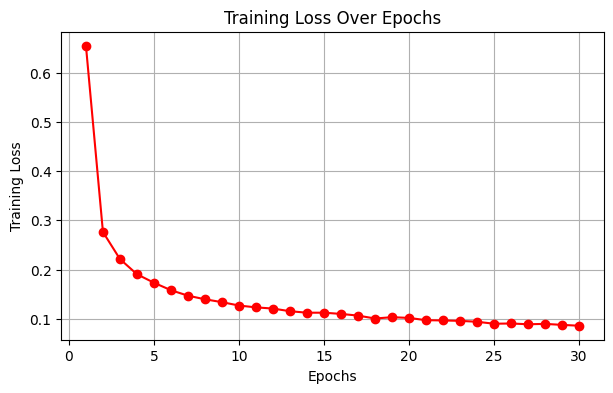

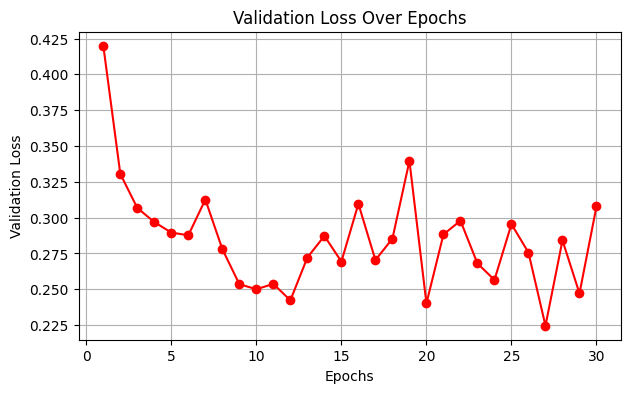

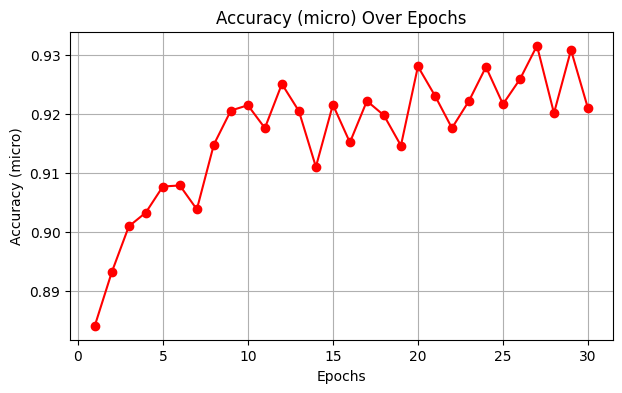

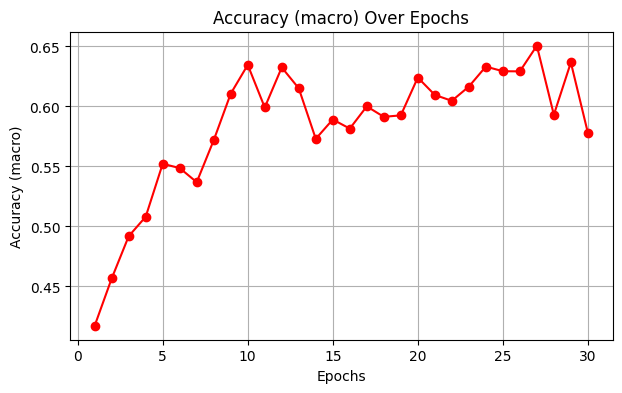

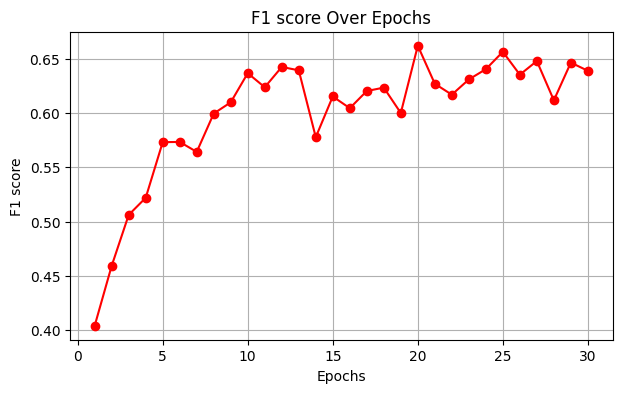

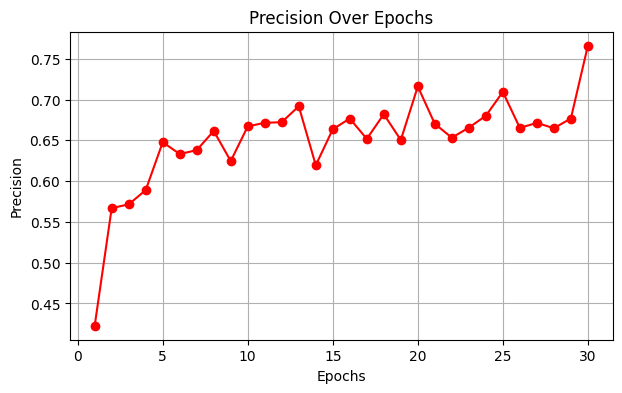

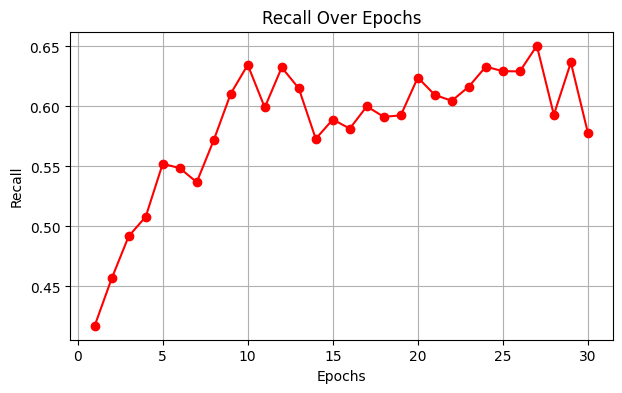

✅ Plots saved to: results\HarTransformer_2025-04-19_23-13-28
✅ Metric histories saved to: results\HarTransformer_2025-04-19_23-13-28\metric_histories.pth


In [25]:
save_dir = save_training_plots_and_metric_history(
    training_loss_history, validation_loss_history, micro_accuracy_history, macro_accuracy_history,
    f1_history, precision_history, recall_history, type(model).__name__
)

## 4. Testing

In [26]:
# Test metrics
loss, micro_accuracy, macro_accuracy, f1, precision, recall, conf_matrix = evaluate_HAR70_model(model, test_dataloader, normalizer)
print(f"(Test) Loss: {loss:.4f}, Accuracy (micro): {micro_accuracy:.4f}, Accuracy (macro): {macro_accuracy:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

(Test) Loss: 0.4296, Accuracy (micro): 0.8893, Accuracy (macro): 0.6294, F1: 0.6402, Precision: 0.6865, Recall: 0.6294


The `process_confusion_matrix` helper function below takes in the confusion matrix (unnormalized) and does the following:
- Saves the confusion matrix (numpy array) as a `npy` file. This can be loaded back in with `np.load`. 
- Recomputes the metrics (accuracy, f1, etc.) from the matrix and saves it as a  `txt` file.
    - The function returns the computed metrics.
- Plots the confusion matrix and saves it as `png` file.
- Normalizes the confusion matrix, then plots and saves it as `png` file.

✅ Confusion Matrix saved to: results\HarTransformer_2025-04-19_23-13-28\conf_matrix_12labels.npy
✅ Confusion Matrix Metrics saved to: results\HarTransformer_2025-04-19_23-13-28\conf_matrix_12labels_metrics.txt


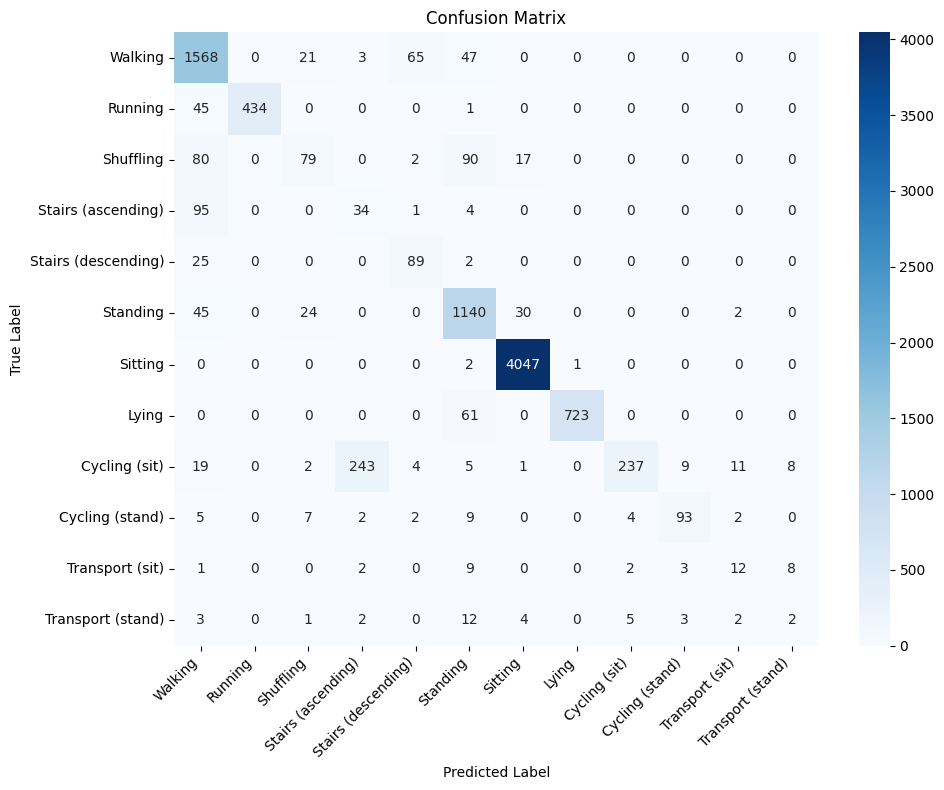

✅ Confusion Matrix Visualization saved to: results\HarTransformer_2025-04-19_23-13-28\conf_matrix_12labels.png


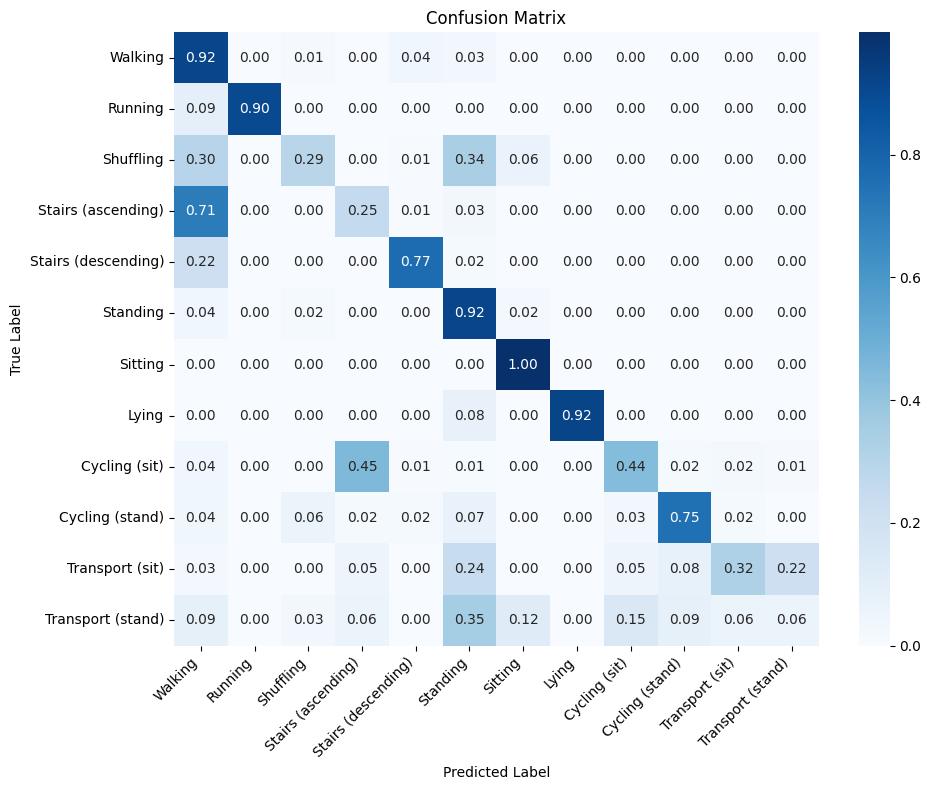

✅ Confusion Matrix Visualization saved to: results\HarTransformer_2025-04-19_23-13-28\conf_matrix_12labels_norm.png


{'micro_accuracy': 0.8892860897907686,
 'macro_accuracy': 0.6294184556314076,
 'precision': 0.6865266269369212,
 'recall': 0.6294184556314076,
 'f1': 0.6401735741890336}

In [27]:
file_name = "conf_matrix_12labels" # Base file name

# `class_names` is a list of label values
class_names = [
    "Walking", # Label 0
    "Running",
    "Shuffling",
    "Stairs (ascending)",
    "Stairs (descending)",
    "Standing",
    "Sitting",
    "Lying",
    "Cycling (sit)",
    "Cycling (stand)",
    "Transport (sit)",
    "Transport (stand)" # Label 11
] # Original label mapping (12)

metric_results = process_confusion_matrix(
    save_dir=save_dir,
    class_names=class_names,
    conf_matrix=conf_matrix,
    file_name=file_name
)
metric_results

For further analysis, we can **merge/ignore classes** in the confusion matrix as it was done in the original dataset papers. This is because some labels involve a very similar physical activity even though they have a different label.
We follow the exact same merges done in the HARTH paper:
- Shuffling, transport (standing), and standing are fused to the same physical activity "standing".
- Sitting and transport (sitting) are merged into "sitting".

Merging involves summing up the corresponding columns and rows in the summed confusion matrix, respectively, resulting in nine activity labels.

In [28]:
# Original class labels
list(enumerate(class_names))

[(0, 'Walking'),
 (1, 'Running'),
 (2, 'Shuffling'),
 (3, 'Stairs (ascending)'),
 (4, 'Stairs (descending)'),
 (5, 'Standing'),
 (6, 'Sitting'),
 (7, 'Lying'),
 (8, 'Cycling (sit)'),
 (9, 'Cycling (stand)'),
 (10, 'Transport (sit)'),
 (11, 'Transport (stand)')]

In [29]:
# Merge the following labels
merge_groups = [
    [2, 5, 11], # Shuffling + Standing + Transport (stand) 
    [6, 10], # Sitting (stand) + Transport (sit)
]
merge_names = [
    "Standing*",
    "Sitting*"
]

updated_conf_matrix, updated_class_names = merge_multiple_classes(
    conf_matrix=conf_matrix,
    class_names=class_names,
    merge_groups=merge_groups,
    merge_names=merge_names
)
list(enumerate(updated_class_names))

[(0, 'Standing*'),
 (1, 'Sitting*'),
 (2, 'Walking'),
 (3, 'Running'),
 (4, 'Stairs (ascending)'),
 (5, 'Stairs (descending)'),
 (6, 'Lying'),
 (7, 'Cycling (sit)'),
 (8, 'Cycling (stand)')]

✅ Confusion Matrix saved to: results\HarTransformer_2025-04-19_23-13-28\conf_matrix_9labels.npy
✅ Confusion Matrix Metrics saved to: results\HarTransformer_2025-04-19_23-13-28\conf_matrix_9labels_metrics.txt


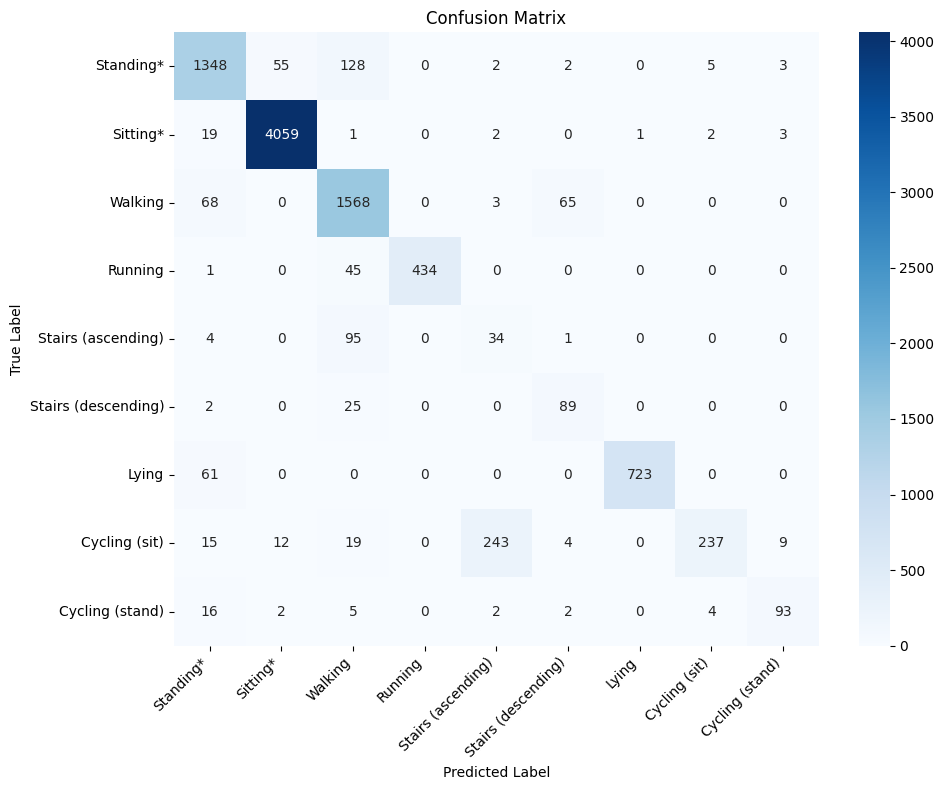

✅ Confusion Matrix Visualization saved to: results\HarTransformer_2025-04-19_23-13-28\conf_matrix_9labels.png


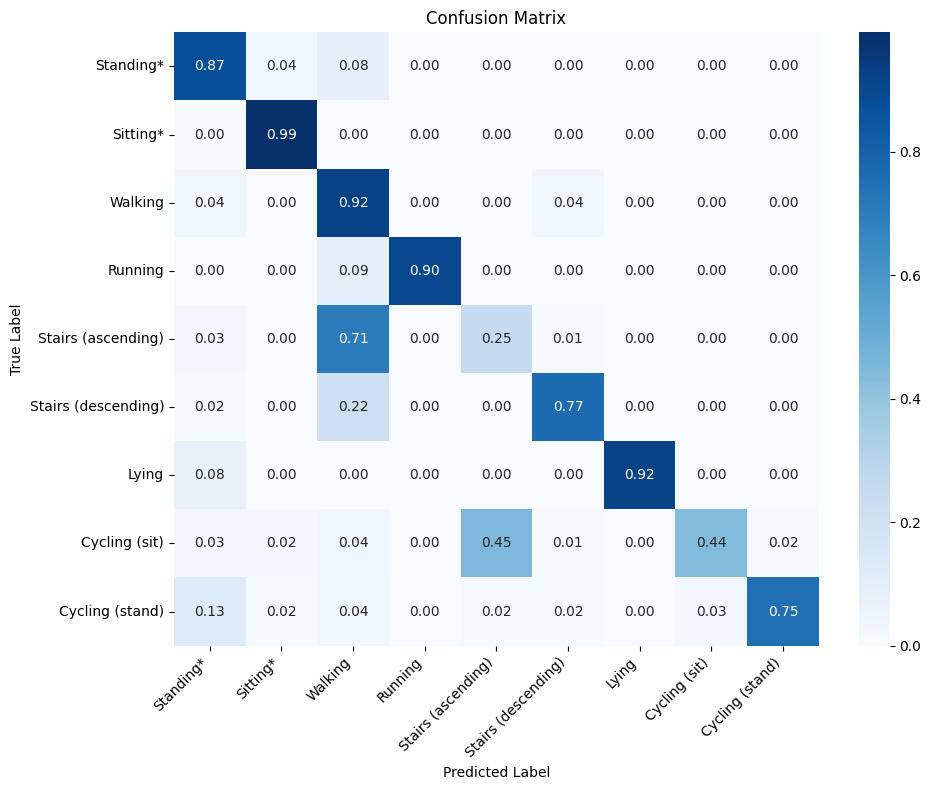

✅ Confusion Matrix Visualization saved to: results\HarTransformer_2025-04-19_23-13-28\conf_matrix_9labels_norm.png


{'micro_accuracy': 0.9026390495216066,
 'macro_accuracy': 0.758221781775926,
 'precision': 0.7970767648003739,
 'recall': 0.758221781775926,
 'f1': 0.7611527381123815}

In [30]:
file_name = "conf_matrix_9labels"
metric_results = process_confusion_matrix(
    save_dir=save_dir,
    class_names=updated_class_names, # Updated class names (merged)
    conf_matrix=updated_conf_matrix, # Updated confusion matrix (merged)
    file_name=file_name
)
metric_results

In [31]:
# Save session information
save_model_information(
    # Dataset Config:
    save_dir=save_dir, 
    sequence_size=sequence_size, 
    stride=stride, 
    num_train=num_train, 
    num_val=num_val, 
    num_test=num_test, 
    random_state=SEED,
    # Training Hyperparams:
    optimizer_name=type(optimizer).__name__,
    batch_size=batch_size,
    learning_rate=learning_rate,
    num_epochs=num_epochs,
    weight_decay=weight_decay,
    # Model Hyperparams:
    model_kwargs=model_kwargs,
    # Test Results:
    loss=loss,
    micro_accuracy=micro_accuracy,
    macro_accuracy=macro_accuracy,
    f1=f1,
    precision=precision,
    recall=recall
)

✅ Saved variable information to results\HarTransformer_2025-04-19_23-13-28\model_info.txt
